## Comparitive Analysis of Community Detection Algorithms

### Necessary Imports

In [10]:
import twitter
import sys
import time
from urllib.request import URLError
from http.client import BadStatusLine
import json
from functools import partial
from sys import maxsize as maxint
import numpy as np
import collections
import networkx as nx
import matplotlib.pyplot as plt
import logging
import pickle

### Function for instantiating a connector to Twitter API 

In [10]:
def oauth_login():
    # Consumer API Keys
    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    
    # OAUTH_TOKEN and OAUTH_TOKEN_SECRET
    OAUTH_TOKEN = ''
    OAUTH_TOKEN_SECRET = ''
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)
    return twitter.Twitter(auth=auth)

### Function taken from Twitter Cookbook for making valid requests to Twitter API

In [11]:
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            logger.error('Too many retries. Quitting.')
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            logger.error('Encountered 401 Error (Not Authorized)')
            return None
        elif e.e.code == 404:
            logger.error('Encountered 404 Error (Not Found)')
            return None
        elif e.e.code == 429: 
            logger.error('Encountered 429 Error (Rate Limit Exceeded)')
            if sleep_when_rate_limited:
                logger.error("Retrying in 15 minutes...ZzZ...")
#                 sys.stderr.flush()
                time.sleep(60*15 + 5)
                logger.error('...ZzZ...Awake now and trying again.')
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            logger.error('Encountered {0} Error. Retrying in {1} seconds'.format(e.e.code, wait_period))
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            logger.error("URLError encountered. Continuing.")
            if error_count > max_errors:
                logger.error("Too many consecutive errors...bailing out.")
                raise
        except BadStatusLine as e:
            error_count += 1
            logger.error("BadStatusLine encountered. Continuing.")
            if error_count > max_errors:
                logger.error("Too many consecutive errors...bailing out.")
                raise

### Function taken from Twitter Cookbook for requesting user information for a given list of screen names or list of user_ids

In [12]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"
    
    items_to_info = {}

    items = screen_names or user_ids
    
    while len(items) > 0:

        # Process 100 items at a time per the API specifications for /users/lookup.
        # See https://dev.twitter.com/docs/api/1.1/get/users/lookup for details.
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, 
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, 
                                            user_id=items_str)
    
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info

    return items_to_info

### Function taken from Twitter Cookbook for getting a list of both Friends and Followers for a given screen name or user_id 

In [13]:
def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
 
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                                count=5000)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
#             print('Fetched {0} total {1} ids for {2}'.format(len(ids), 
#                                                     label, (user_id or screen_name)),file = sys.stderr)
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

### Crawler function for performing BFS using a either Screen Name or User Id as starting point

In [14]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency 
    # in storage

    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    
    friends_ids, _ = get_friends_followers_ids(twitter_api, user_id=seed_id, 
                                              friends_limit=limit, followers_limit=0)
    
    u_nwt = collections.OrderedDict()
#     u_nwt[int(seed_id)] = {'friends' : friends_ids, 'followers': followers_ids}
    u_nwt[int(seed_id)] = friends_ids
    
    next_queue = friends_ids
    d = 1
    
    logger.info('Depth     :  {}'.format(d))
    logger.info('USER_ID  :  {}'.format(seed_id))
    logger.info('FRIENDS  :  {}'.format(friends_ids))
#     logger.info('FOLLOWERS    :  {}'.format(followers_ids))
    logger.info('\n')
    
    while d < depth:
        d += 1
        (queue, next_queue) = (next_queue, [])
        for fid in queue:
            friends_ids, _ = get_friends_followers_ids(twitter_api, user_id=fid, 
                                                     friends_limit=limit, 
                                                     followers_limit=0)
            
            logger.info('Depth     :  {}'.format(d))
            logger.info('USER_ID  :  {}'.format(fid))
            logger.info('FRIENDS  :  {}'.format(friends_ids))
#             logger.info('FOLLOWERS    :  {}'.format(followers_ids))
            logger.info('\n')
            
            if fid not in u_nwt.keys():
#                 u_nwt[fid] = {'friends' : friends_ids, 'followers': followers_ids}
                u_nwt[fid] = friends_ids
            next_queue += friends_ids
#             next_queue += followers_ids
    
    return u_nwt

In [69]:
%%time

# initializing logger file, loggin format and loggin level
logging.basicConfig(filename="crawler.log", format='%(asctime)s %(message)s', filemode='w') 
logger=logging.getLogger() 
logger.setLevel(logging.DEBUG)

logger.info('Starting.......')

screen_name = "muditdham"
logger.info('ROOT     :  {}'.format(screen_name))

twitter_api = oauth_login()
user_network = crawl_followers(twitter_api, screen_name, limit=50, depth=3)

# Save the user network dictionary as pickle or later use (additionally for safe keeping)
with open('user_network_{}.pickle'.format(screen_name),'wb') as f:
    pickle.dump(user_network, f, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 41.4 s, sys: 7.54 s, total: 48.9 s
Wall time: 2d 22h 43min 17s


### Checkpoint 1 - Plotting Social Network for Limited Followers - 25 

In [5]:
with open('./user_network.pickle', 'rb') as f:
    user_network = pickle.load(f)

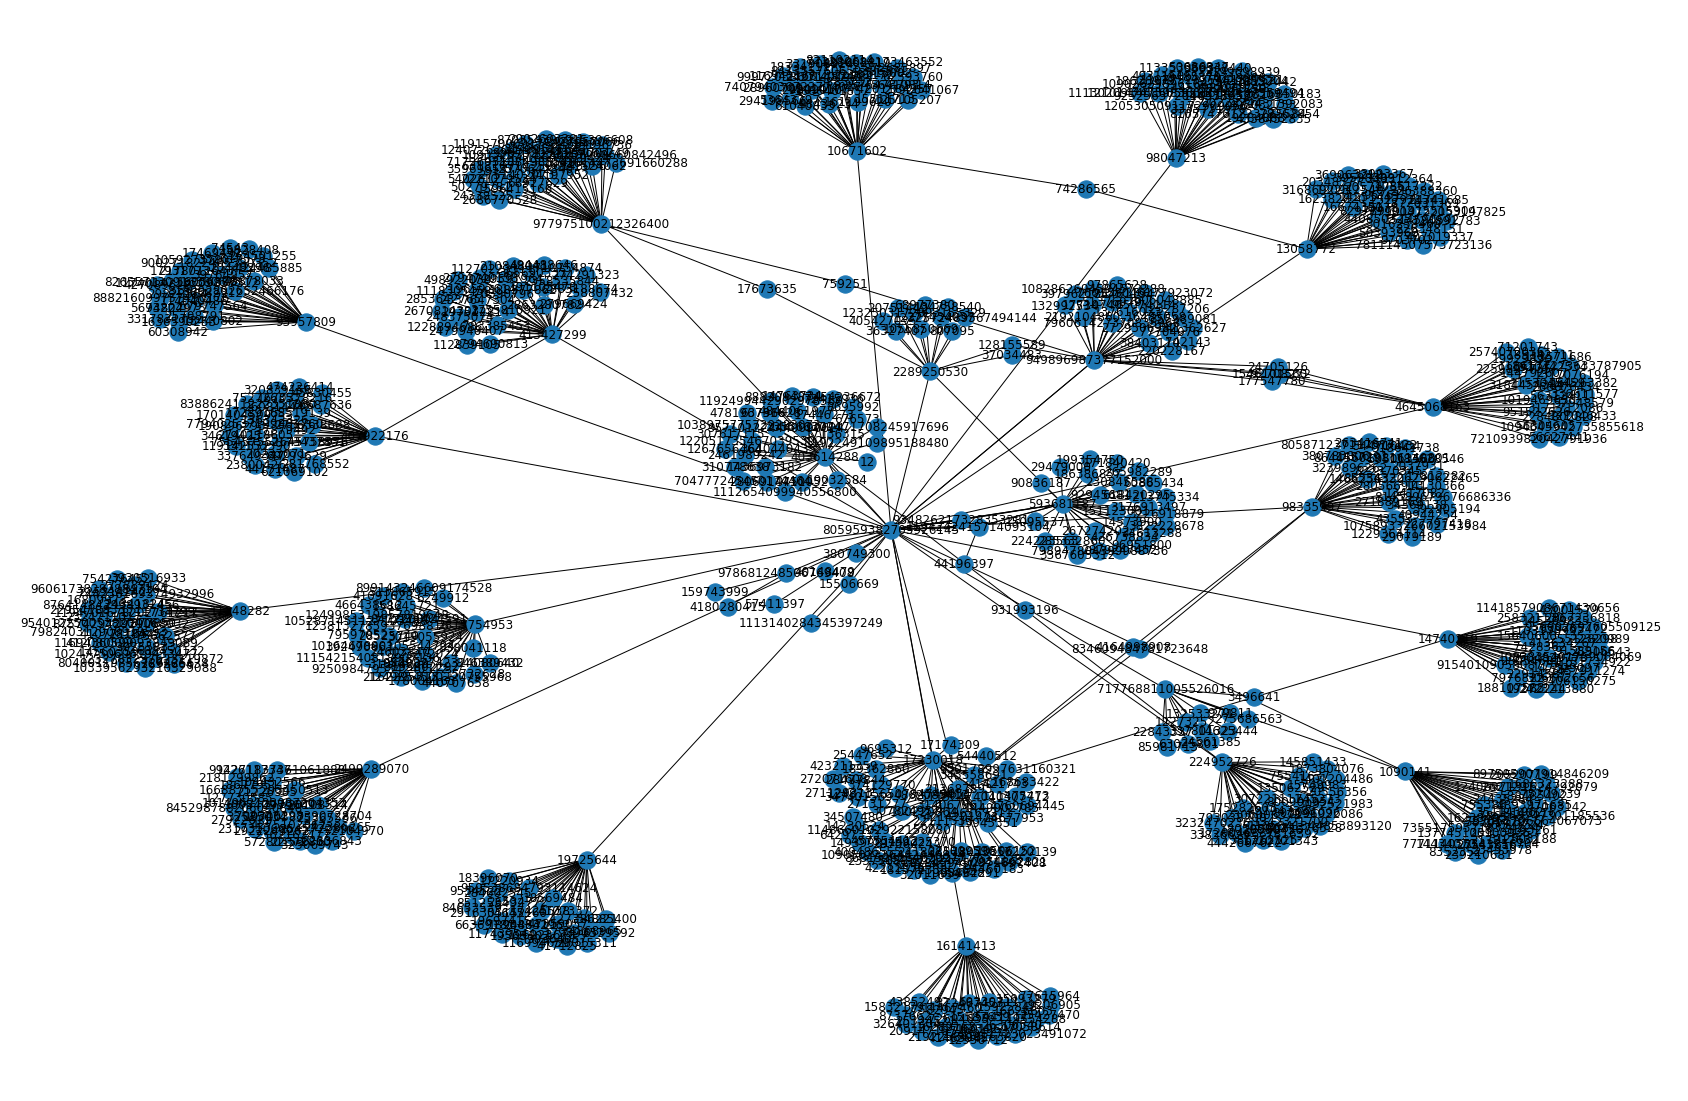

In [51]:
g = nx.MultiGraph()

# add all user nodes to network graph
_ = g.add_nodes_from(user_network.keys())

# add edges to network graph
for k, v in user_network.items():
    _ = g.add_edges_from(([(k, t) for t in v]))

# plot network graph    
fig, ax = plt.subplots(figsize=(30,20))
_ = nx.draw(g, with_labels=True, ax=ax)

# save network graph as png 
_ = fig.savefig('./network-graph-mudhitdham.png')

### Checkpoint 2 - Plotting Social Network for 100 followers at every depth 

In [6]:
with open('./user_network_muditdham.pickle', 'rb') as f:
    user_network = pickle.load(f)

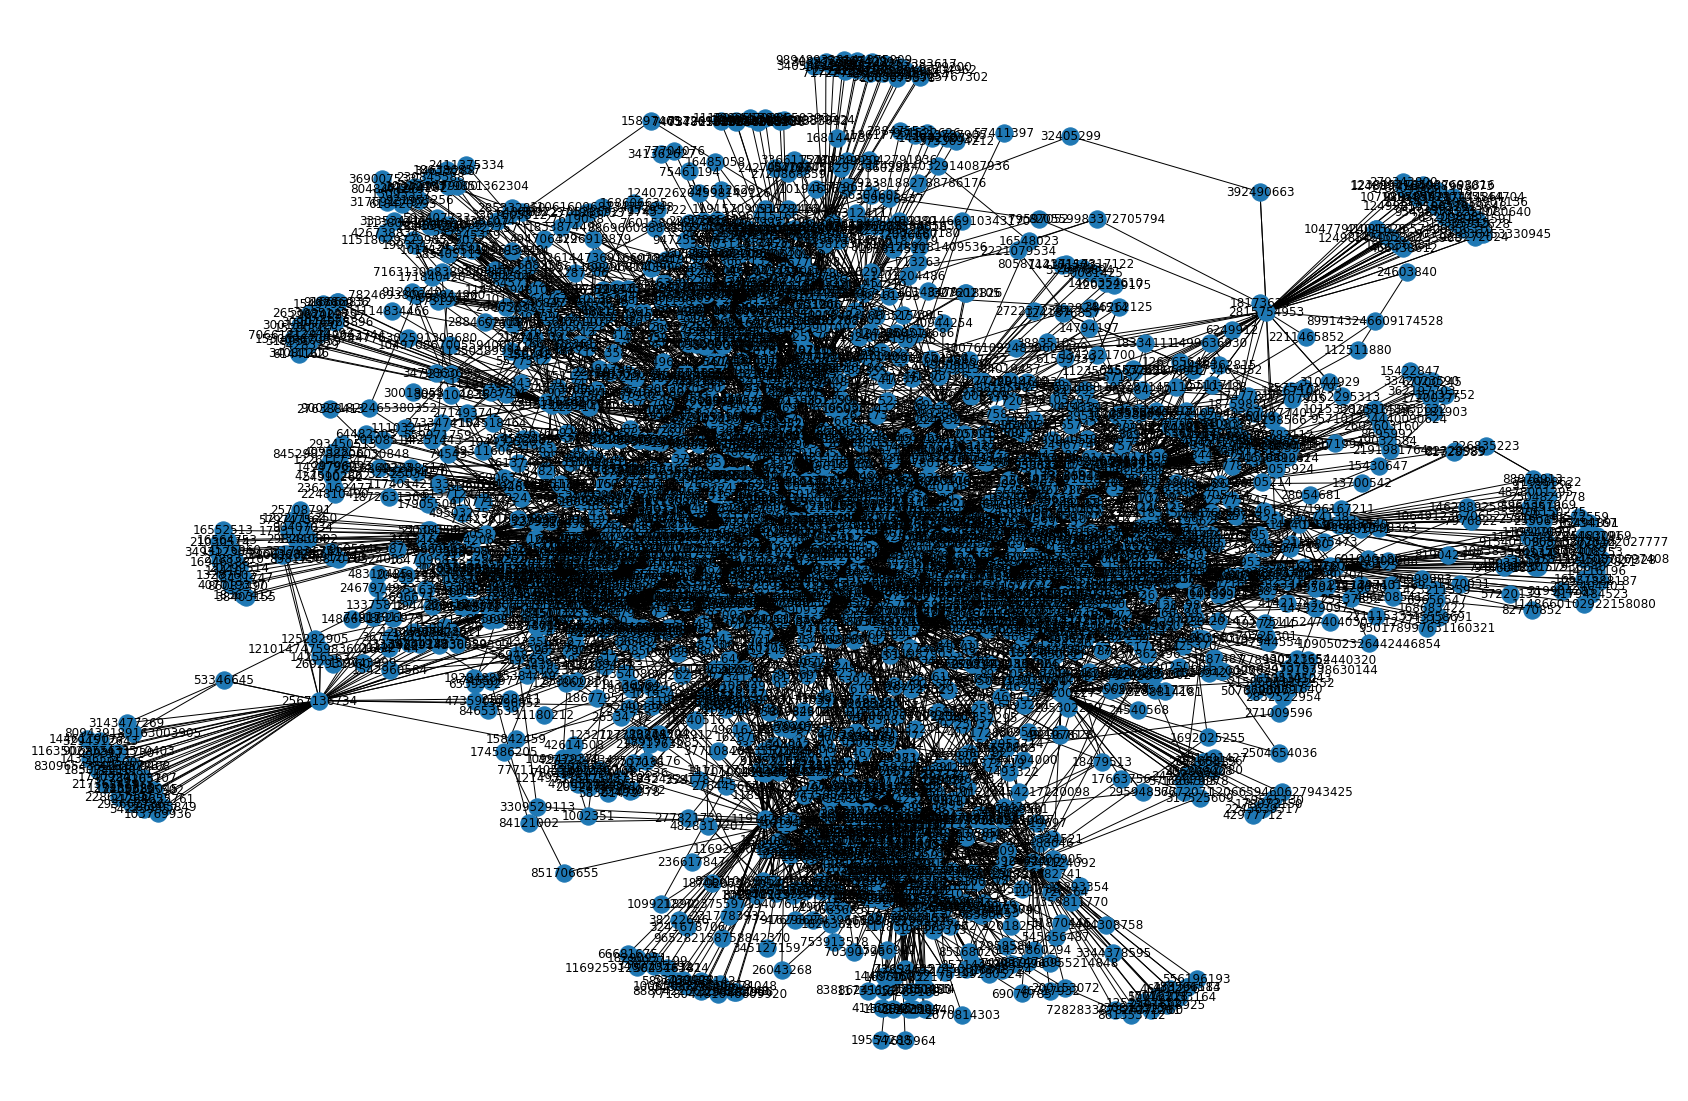

In [21]:
g = nx.MultiGraph()

# add all user nodes to network graph
_ = g.add_nodes_from(user_network.keys())

# add edges to network graph
for k, v in user_network.items():
    _ = g.add_edges_from(([(k, t) for t in v]))

fig, ax = plt.subplots(figsize=(30,20))
_ = nx.draw(g, with_labels=True, ax=ax)

# save network graph as png
_ = fig.savefig('./network-graph-mudhitdham-1.png')

### Nodes

In [17]:
len(user_profiles.keys())

1971